In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [45]:
#import training dataset

dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_12_12_b/torch_dataset_all.pkl')

print(dataset)
print(len(dataset))

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
cmd_left_vels_array = dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels_array = dataset[encoder_left_str_list].to_numpy()
encoder_right_vels_array = dataset[encoder_right_str_list].to_numpy()

# import input space info
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)

# import model error
ideal_diff_drive_errors_dataframe = pd.read_pickle('../data/marmotte/eval_results/grand_salon_b/ideal_diff_drive_full_eval_metrics.pkl')
enhanced_kinematic_errors_dataframe = pd.read_pickle('../data/marmotte/eval_results/grand_salon_b/enhanced_kinematic_full_eval_metrics.pkl')
print(ideal_diff_drive_errors_dataframe)
print(len(ideal_diff_drive_errors_dataframe))

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0      0.000000    0.000000    0.000000       0.000000        0.000000   
1      0.008955   -0.000817    0.003175      -0.001797        0.006842   
2      0.007267   -0.000082    0.001521      -0.002199        0.006909   
3      0.006334   -0.001298    0.002206      -0.001787        0.007261   
4      0.005491   -0.000265    0.001215      -0.001595        0.006859   
..          ...         ...         ...            ...             ...   
734   -4.908478   -0.194696   -0.075796       0.007526        0.014339   
735   -6.110772   -0.703211   -0.051747      -0.018082        0.002857   
736   -6.120254   -0.691927   -0.046963      -0.005544        0.011006   
737   -6.119847   -0.692307   -0.048081      -0.005805        0.011418   
738   -6.121067   -0.691024   -0.047965      -0.005566        0.011321   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0        0.000000         0.0     0.

In [46]:
def confidence_ellipse(x, y, ax, n_std=3, **kwargs):
    """
    Create a plot of the covariation confidence ellipse op `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data

    Returns
    -------
    float: the Pearson Correlation Coefficient for `x` and `y`.

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties

    author : Carsten Schelp
    license: GNU General Public License v3.0 (https://github.com/CarstenSchelp/CarstenSchelp.github.io/blob/master/LICENSE)
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1,1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    # calculating the stdandarddeviation of x from  the squareroot of the variance
    # np.sqrt(cov[0, 0])
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    
    # calculating the stdandarddeviation of y from  the squareroot of the variance
    # np.sqrt(cov[1, 1])
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
        
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
        
    return pearson        
    # render plot with "plt.show()".

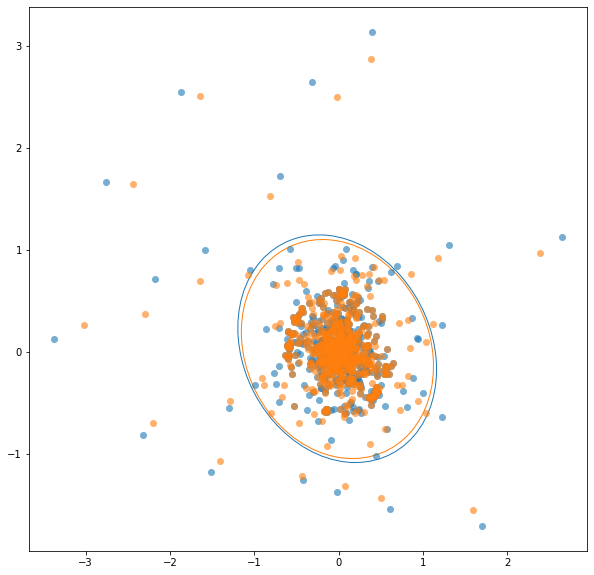

In [60]:
# plot model errors

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

# compute x-y covariance ideal diff drive
trans_error_array = np.zeros((len(ideal_diff_drive_errors_dataframe), 2))
trans_error_array[:, 0] = ideal_diff_drive_errors_dataframe['prediction_error_x'].to_numpy()
trans_error_array[:, 1] = ideal_diff_drive_errors_dataframe['prediction_error_y'].to_numpy()
trans_error_cov = np.cov(trans_error_array)
confidence_ellipse(trans_error_array[:, 0], trans_error_array[:, 1], ax, n_std=3, facecolor='none', edgecolor='C0')

# compute x-y covariance ideal diff drive
trans_error_array = np.zeros((len(enhanced_kinematic_errors_dataframe), 2))
trans_error_array[:, 0] = enhanced_kinematic_errors_dataframe['prediction_error_x'].to_numpy()
trans_error_array[:, 1] = enhanced_kinematic_errors_dataframe['prediction_error_y'].to_numpy()
trans_error_cov = np.cov(trans_error_array)
confidence_ellipse(trans_error_array[:, 0], trans_error_array[:, 1], ax, n_std=3, facecolor='none', edgecolor='C1')

line_width = 5
alpha = 0.2

alpha_plot = 0.6

idd = ax.scatter(ideal_diff_drive_errors_dataframe['prediction_error_x'], ideal_diff_drive_errors_dataframe['prediction_error_y'], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

ek = ax.scatter(enhanced_kinematic_errors_dataframe['prediction_error_x'], enhanced_kinematic_errors_dataframe['prediction_error_y'], 
                  c = 'C1', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

0.8926651613203622
0.8894098493580507


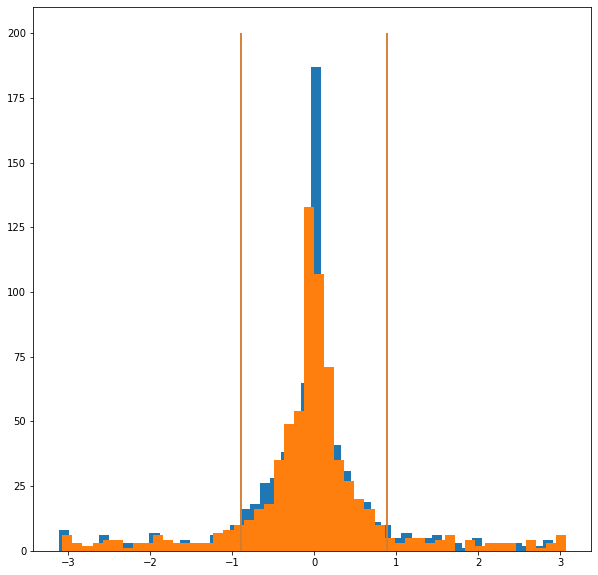

In [59]:
# plot model errors

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2

alpha_plot = 0.6

idd = ax.hist(ideal_diff_drive_errors_dataframe['prediction_error_yaw'].to_numpy(), 50)
idd_std_dev = np.std(ideal_diff_drive_errors_dataframe['prediction_error_yaw'].to_numpy())
ax.vlines(np.array([-idd_std_dev, idd_std_dev]), 0, 200)

ek = ax.hist(enhanced_kinematic_errors_dataframe['prediction_error_yaw'].to_numpy(), 50)
ek_std_dev = np.std(enhanced_kinematic_errors_dataframe['prediction_error_yaw'].to_numpy())
ax.vlines(np.array([-ek_std_dev, ek_std_dev]), 0, 200, color='C1')

print(idd_std_dev)
print(ek_std_dev)

In [28]:
# compute Seegmiller param metrics

idd_vx_p2 = ideal_diff_drive_errors_dataframe['body_model_vx']
idd_vy_p3 = ideal_diff_drive_errors_dataframe['body_model_vy']
idd_omega_p6 = ideal_diff_drive_errors_dataframe['body_model_omega']

# icp GT values
icp_vx = ideal_diff_drive_errors_dataframe['body_icp_vx']
icp_vy = ideal_diff_drive_errors_dataframe['body_icp_vy']
icp_omega = ideal_diff_drive_errors_dataframe['body_icp_omega']

print(np.max(idd_vy_p3))

3.074540113326979e-15


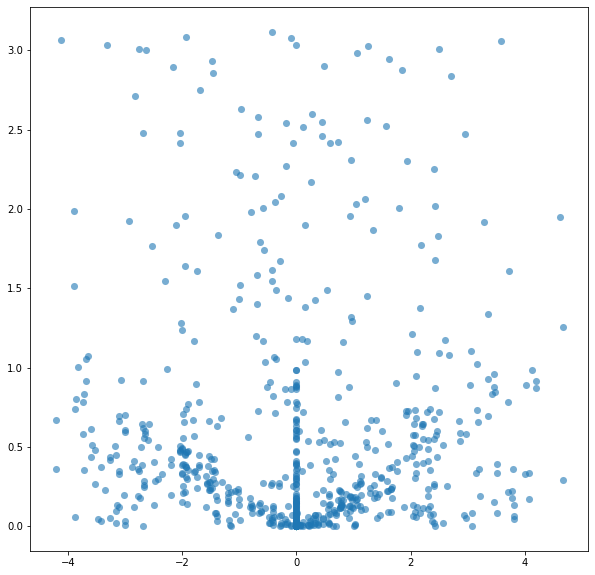

In [29]:
# plot idd ang error vs angular vel (angular slip)

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2

alpha_plot = 0.6

idd = ax.scatter(idd_omega_p6, ideal_diff_drive_errors_dataframe['prediction_error_3dof_ang'], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans']

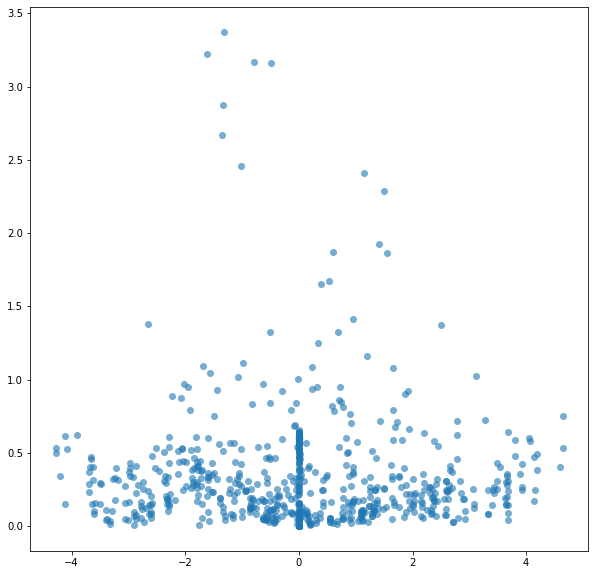

In [30]:
# plot idd trans error vs lin vel (lin + lat slip)

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2

alpha_plot = 0.6

idd = ax.scatter(idd_vx_p2 + idd_omega_p6, ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans'], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans']

In [31]:
# estimate wheel acceleration during windows

n_windows = len(dataset)
max_left_diff_window = 0

linear_acceleration_array = np.zeros(n_windows)
angular_acceleration_array = np.zeros(n_windows)

for i in range(0, n_windows):
    body_vel_init = ideal_diff_drive.compute_body_vel(np.array([cmd_left_vels_array[i, 0], cmd_right_vels_array[i, 0]]))
    body_vel_end = ideal_diff_drive.compute_body_vel(np.array([cmd_left_vels_array[i, 39], cmd_right_vels_array[i, 39]]))
    linear_acceleration_array[i] = body_vel_end[0] - body_vel_init[0]
    angular_acceleration_array[i] = body_vel_end[1] - body_vel_init[1]
    
print(linear_acceleration_array.shape)
print(len(ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans']))

(739,)
739


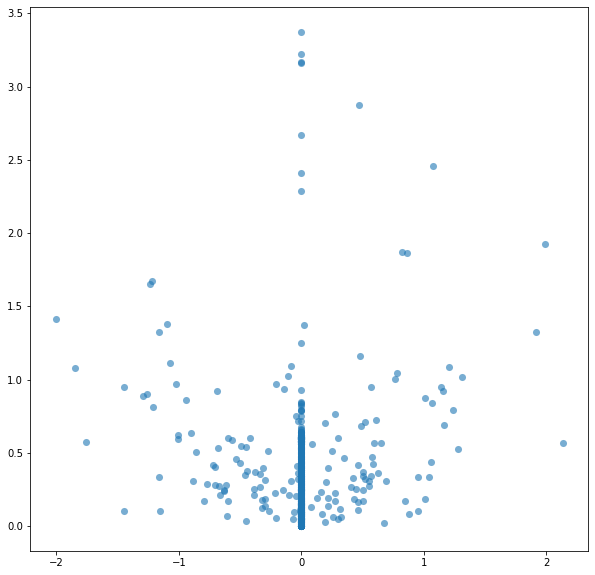

In [32]:
# plot idd trans error vs lin acc

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2

alpha_plot = 0.6

idd = ax.scatter(linear_acceleration_array, ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans'], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans']

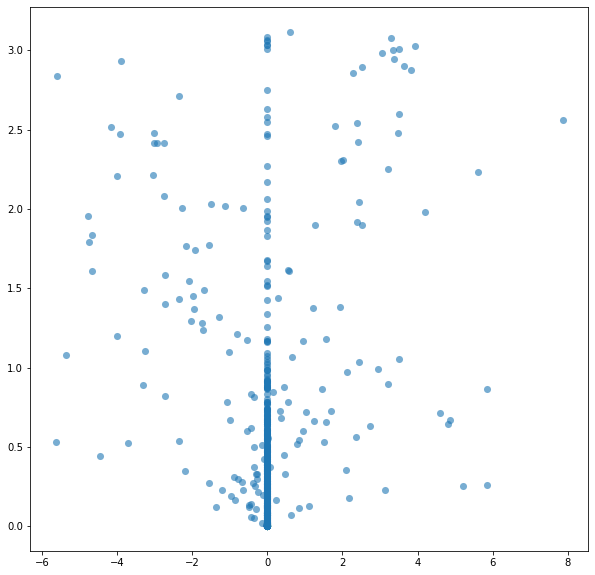

In [33]:
# plot idd trans error vs lin acc

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2

alpha_plot = 0.6

idd = ax.scatter(angular_acceleration_array, ideal_diff_drive_errors_dataframe['prediction_error_3dof_ang'], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# ideal_diff_drive_errors_dataframe['prediction_error_3dof_trans']